In [1]:
import scipy.io
import os
import numpy as np

In [2]:
# Define the main path and file paths
main_path = r'D:\Fateme A\23_Brain Electrophysiological Recording during Olfactory Stimulation in Mild Cognitive Impairment and Alzheimer Disease Patients An EEG Dataset'

In [3]:
import os
import numpy as np
import scipy.io
import random

# Define file names
file_paths = {
    "AD": os.path.join(main_path, "AD.mat"),
    "normal": os.path.join(main_path, "normal.mat"),
    "MCI": os.path.join(main_path, "MCI.mat")
}

# Prepare storage per class
class_data = {
    "AD": [],
    "normal": [],
    "MCI": []
}

# Load and organize all trials by class
for label, file_path in file_paths.items():
    mat_data = scipy.io.loadmat(file_path)
    eeg_data = mat_data[label]  # Assuming variable name matches label

    for patient_id in range(eeg_data.shape[1]):  # shape: (1, N_patients)
        patient_data = eeg_data[0][patient_id]
        trials = patient_data[0]  # shape: channels x samples x trials

        # Split into individual trials and add to class list
        for i in range(trials.shape[2]):
            class_data[label].append(trials[:, :, i])  # One trial

# Calculate total trial counts per class
trial_counts = {label: len(trials) for label, trials in class_data.items()}
print("Trial counts per class:", trial_counts)

# Find the minimum number of trials across the 3 classes
min_trial_count = min(trial_counts.values())
print("trial number to balance classes:", min_trial_count)

# Randomly select min_trial_count trials from each class
balanced_data = []
balanced_labels = []

for label in class_data:
    selected_trials = random.sample(class_data[label], min_trial_count)
    balanced_data.extend(selected_trials)
    balanced_labels.extend([label] * min_trial_count)

# Convert to arrays
data_array = np.stack(balanced_data)  # shape: total_trials x channels x samples
labels_array = np.array(balanced_labels)

# Final output info
print("3 * 848 = ", data_array.shape[0])
print('we used random selection of trials to balance classes')

print("Final balanced dataset:")
print("Data shape:", data_array.shape)
print("Labels shape:", labels_array.shape)
print("Labels:", np.unique(labels_array, return_counts=True))


Trial counts per class: {'AD': 1352, 'normal': 1677, 'MCI': 848}
trial number to balance classes: 848
3 * 848 =  2544
we used random selection of trials to balance classes
Final balanced dataset:
Data shape: (2544, 4, 600)
Labels shape: (2544,)
Labels: (array(['AD', 'MCI', 'normal'], dtype='<U6'), array([848, 848, 848]))


## Transfer Entropy Function

In [4]:
import numpy as np
from scipy.signal import hilbert
from sklearn.preprocessing import KBinsDiscretizer

def compute_phase(signal):
    """Compute instantaneous phase via Hilbert transform."""
    analytic_signal = hilbert(signal)
    phase = np.angle(analytic_signal)
    return phase

def bin_phases(phases, n_bins):
    """Discretize continuous phases into n_bins states uniformly."""
    # phases in [-π, π]
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform', subsample=None)
    return est.fit_transform(phases.reshape(-1, 1)).astype(int).flatten()

def estimate_joint_probabilities(data, n_bins):
    """Estimate joint probability distribution from 2D array of binned variables."""
    # Each row = variable, columns = samples
    # data.shape = (variables, N)
    variables, N = data.shape
    joint_counts = np.zeros([n_bins]*variables, dtype=np.float64)
    for i in range(N):
        idx = tuple(data[:, i])
        joint_counts[idx] += 1
    joint_probs = joint_counts / joint_counts.sum()
    return joint_probs

def phase_transfer_entropy(signal_a, signal_b, delta=1, n_bins=8):
    """
    Computes Phase Transfer Entropy from signal_b (driver) to signal_a (target)
    using the formula from the image.
    """
    # Step 1: Compute instantaneous phases
    phase_a = compute_phase(signal_a)
    phase_b = compute_phase(signal_b)

    # Step 2: Embed
    # A_delta = future of A
    A_delta = phase_a[delta:]
    A_past = phase_a[:-delta]
    B_past = phase_b[:-delta]

    N_effective = len(A_delta)

    # Step 3: Bin phases
    A_delta_binned = bin_phases(A_delta, n_bins)
    A_past_binned = bin_phases(A_past, n_bins)
    B_past_binned = bin_phases(B_past, n_bins)

    # Step 4: Build joint data
    data_A_delta_A_B = np.vstack([A_delta_binned, A_past_binned, B_past_binned])
    data_A_delta_A = np.vstack([A_delta_binned, A_past_binned])

    # Step 5: Estimate probabilities
    p_A_delta_A_B = estimate_joint_probabilities(data_A_delta_A_B, n_bins)
    p_A_delta_A = estimate_joint_probabilities(data_A_delta_A, n_bins)

    # Step 6: Compute sum
    PTE = 0.0
    for i in range(n_bins):
        for j in range(n_bins):
            for k in range(n_bins):
                p_joint = p_A_delta_A_B[i, j, k]
                if p_joint == 0:
                    continue

                p_cond_AB = p_joint / (p_A_delta_A_B[:, j, k].sum() + 1e-12)
                p_cond_A = p_A_delta_A[i, j] / (p_A_delta_A[:, j].sum() + 1e-12)

                if p_cond_AB > 0 and p_cond_A > 0:
                    PTE += p_joint * np.log2(p_cond_AB / p_cond_A)

    return PTE


## Feature extraction 

In [5]:
from scipy.signal import butter, filtfilt
import numpy as np

# Bandpass filter
def bandpass_filter(signal, lowcut, highcut, fs=200.0, order=3):
    """Apply a Butterworth bandpass filter to a 1D signal."""
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# EEG bands
FREQ_BANDS = {
    "delta": (0.1, 4),
    "theta": (4, 8),
    "alpha": (8, 14),
    "beta": (14, 30),
    "gamma": (30, 40)
}

def process_data(data_array):
    """
    Process EEG data, computing transfer entropy between frequency bands
    for each channel (instead of between channels).
    
    Parameters:
    data_array: numpy array of shape (n_trials, n_channels, n_samples)
    
    Returns:
    X: numpy array of shape (n_trials, n_features)
    feature_names: list of feature names for channel-band pairs
    """
    n_trials, n_channels, n_samples = data_array.shape
    band_names = list(FREQ_BANDS.keys())
    
    # all unique band pairs (e.g., delta→theta, delta→alpha, etc.)
    band_pairs = [(b1, b2) for i, b1 in enumerate(band_names) 
                           for j, b2 in enumerate(band_names) if i < j]

    features = []
    channel_names = ['Fp1', 'Fz', 'Cz', 'Pz'][:n_channels]

    for trial in range(n_trials):
        signal = np.array(data_array[trial, :, :], dtype=np.float64)

        trial_features = []
        for ch_idx in range(n_channels):
            ch_signal = signal[ch_idx]

            # Filter signal into bands
            band_signals = {
                band_name: bandpass_filter(ch_signal, low, high, fs=200)
                for band_name, (low, high) in FREQ_BANDS.items()
            }

            # Compute TE between band pairs for this channel
            for b1, b2 in band_pairs:
                te_val = phase_transfer_entropy(band_signals[b1], band_signals[b2])
                trial_features.append(te_val)
        
        features.append(trial_features)
    
    X = np.array(features)

    # Feature names
    feature_names = []
    for ch in channel_names:
        for b1, b2 in band_pairs:
            feature_names.append(f'TE_{ch}_{b1}_to_{b2}')
    
    return X, feature_names


## Comparing Classifiers


=== Evaluating Phase TE Features with 10-Fold Cross-Validation ===

=== Classifier Performance (10-fold Accuracy) ===
SVM: 0.523 ± 0.027
Random Forest: 0.492 ± 0.020
Naive Bayes: 0.422 ± 0.029
Logistic Regression: 0.420 ± 0.023
Decision Tree: 0.383 ± 0.029


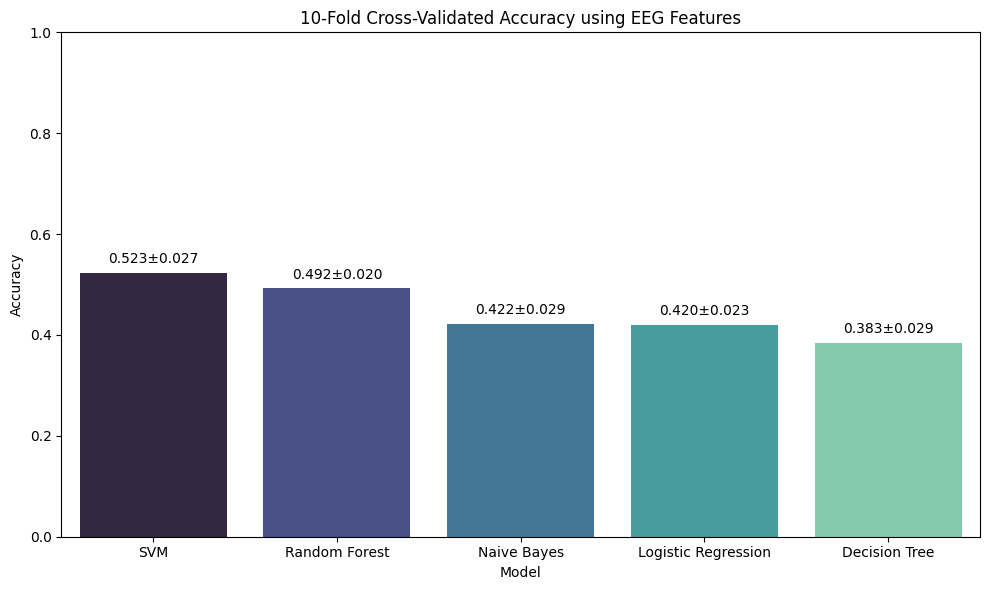

In [7]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Define classifiers
classifiers = {
    'SVM': SVC(kernel='rbf', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(
        random_state=42,
        max_iter=1000,
        solver='lbfgs',
        tol=1e-4,
        C=1.0
    ),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# --- Main evaluation function ---
def evaluate_features(data_array, labels_array):
    print("\n=== Evaluating Phase TE Features with 10-Fold Cross-Validation ===")

    # Extract features
    X, feature_names = process_data(data_array)

    # Encode labels (already balanced, one label per trial)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(labels_array)

    # Cross-validation setup
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    results = {}
    print("\n=== Classifier Performance (10-fold Accuracy) ===")

    for name, clf in classifiers.items():
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', clf)
        ])

        scores = cross_val_score(pipeline, X, y_encoded, cv=skf, scoring='accuracy')

        results[name] = {
            'Mean Accuracy': np.mean(scores),
            'Std Accuracy': np.std(scores),
            'All Scores': scores
        }

        print(f"{name}: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

    # Plot mean accuracies
    accuracy_df = pd.DataFrame({
        'Model': list(results.keys()),
        'Mean Accuracy': [results[m]['Mean Accuracy'] for m in results],
        'Std Accuracy': [results[m]['Std Accuracy'] for m in results]
    }).sort_values(by='Mean Accuracy', ascending=False)

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        x='Model',
        y='Mean Accuracy',
        data=accuracy_df,
        hue='Model',
        palette='mako',
        legend=False
    )

    for p, (_, row) in zip(ax.patches, accuracy_df.iterrows()):
        ax.annotate(f'{row["Mean Accuracy"]:.3f}±{row["Std Accuracy"]:.3f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')

    plt.title("10-Fold Cross-Validated Accuracy using EEG Features")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

    return results

results = evaluate_features(data_array, labels_array)
